In [107]:
# import libraries
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import talib
import seaborn as sns
import statsmodels.api as sm


In [108]:
# Download latest version of yahoo stock price dataset from Kaggle
path = kagglehub.dataset_download("arashnic/time-series-forecasting-with-yahoo-stock-price")
print("Path to dataset files:", path)
yahoo = pd.read_csv(path + "/yahoo_stock.csv")
yahoo['Date'] = pd.to_datetime(yahoo['Date'])
print(yahoo.head())

Path to dataset files: C:\Users\mckin\.cache\kagglehub\datasets\arashnic\time-series-forecasting-with-yahoo-stock-price\versions\3
        Date         High          Low         Open        Close  \
0 2015-11-23  2095.610107  2081.389893  2089.409912  2086.590088   
1 2015-11-24  2094.120117  2070.290039  2084.419922  2089.139893   
2 2015-11-25  2093.000000  2086.300049  2089.300049  2088.870117   
3 2015-11-26  2093.000000  2086.300049  2089.300049  2088.870117   
4 2015-11-27  2093.290039  2084.129883  2088.820068  2090.110107   

         Volume    Adj Close  
0  3.587980e+09  2086.590088  
1  3.884930e+09  2089.139893  
2  2.852940e+09  2088.870117  
3  2.852940e+09  2088.870117  
4  1.466840e+09  2090.110107  


Look at the data

<Axes: >

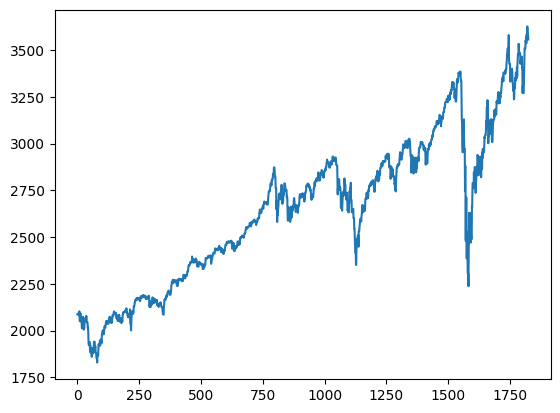

In [109]:
yahoo['Adj Close'].plot()

<Axes: >

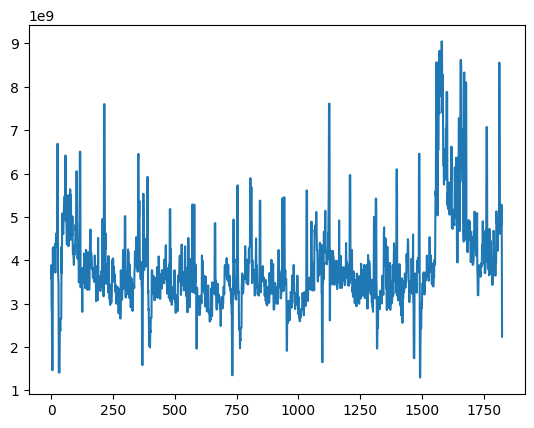

In [110]:
yahoo['Volume'].plot()

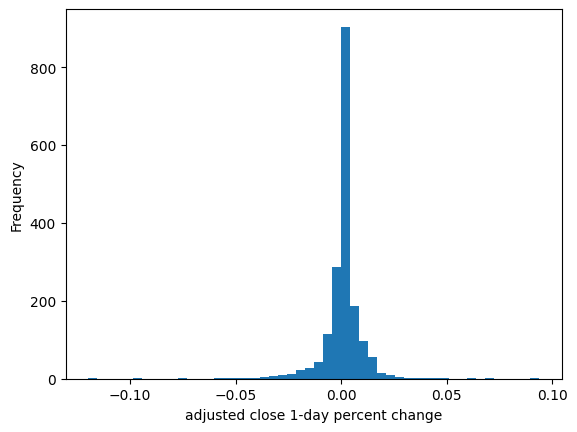

In [111]:
yahoo['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

In [112]:
yahoo['10d_future_close'] = yahoo['Adj Close'].shift(-10)
yahoo['10d_future_close_pct'] = yahoo['10d_future_close'].pct_change(10)
yahoo['10d_close_pct'] = yahoo['Adj Close'].pct_change(10)

print('Lenght of the dataset:', len(yahoo))
print(yahoo.head())

# calculate the correlation matrix between the 5d close percentage changes (current and future)
corr = yahoo[['10d_close_pct', '10d_future_close_pct']].corr()
print(corr)


Lenght of the dataset: 1825
        Date         High          Low         Open        Close  \
0 2015-11-23  2095.610107  2081.389893  2089.409912  2086.590088   
1 2015-11-24  2094.120117  2070.290039  2084.419922  2089.139893   
2 2015-11-25  2093.000000  2086.300049  2089.300049  2088.870117   
3 2015-11-26  2093.000000  2086.300049  2089.300049  2088.870117   
4 2015-11-27  2093.290039  2084.129883  2088.820068  2090.110107   

         Volume    Adj Close  10d_future_close  10d_future_close_pct  \
0  3.587980e+09  2086.590088       2049.620117                   NaN   
1  3.884930e+09  2089.139893       2091.689941                   NaN   
2  2.852940e+09  2088.870117       2091.689941                   NaN   
3  2.852940e+09  2088.870117       2091.689941                   NaN   
4  1.466840e+09  2090.110107       2077.070068                   NaN   

   10d_close_pct  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
                

C:\Users\mckin\AppData\Local\Temp\ipykernel_7020\577908610.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  yahoo['10d_future_close_pct'] = yahoo['10d_future_close'].pct_change(10)


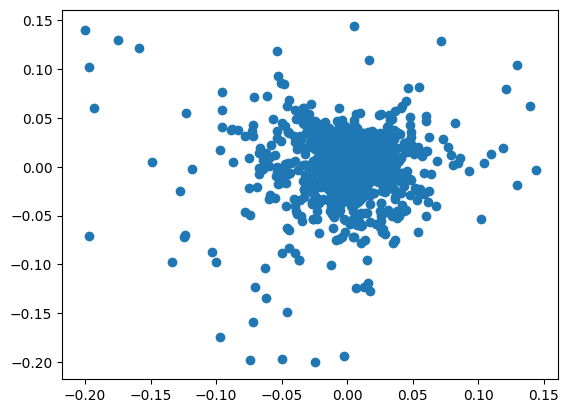

In [113]:
# scatter the current 10-day percent change vs the future 10-day percent change
plt.scatter(yahoo['10d_close_pct'], yahoo['10d_future_close_pct'])
plt.show()

Prepare data for ML

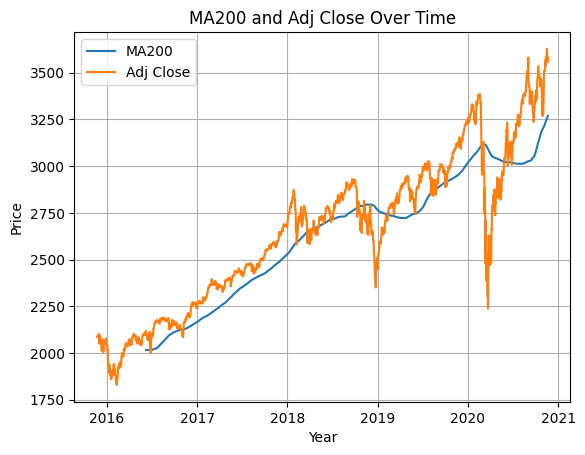

In [114]:
features = yahoo[['10d_close_pct', 'Adj Close', 'Volume']]
# our targets are the future price changes
targets = yahoo['10d_future_close_pct']

yahoo['ma14'] = talib.SMA(yahoo['Adj Close'].values, timeperiod=14)
yahoo['rsi14'] = talib.RSI(yahoo['Adj Close'].values, timeperiod=14)

yahoo['ma30'] = talib.SMA(yahoo['Adj Close'].values, timeperiod=30)
yahoo['rsi30'] = talib.RSI(yahoo['Adj Close'].values, timeperiod=30)

yahoo['ma50'] = talib.SMA(yahoo['Adj Close'].values, timeperiod=50)
yahoo['rsi50'] = talib.RSI(yahoo['Adj Close'].values, timeperiod=50)


yahoo['ma200'] = talib.SMA(yahoo['Adj Close'].values, timeperiod=200)
yahoo['rsi200'] = talib.RSI(yahoo['Adj Close'].values, timeperiod=200)

#plt the adj close price against the 200 day moving average
plt.plot(yahoo['Date'], yahoo['ma200'], label='MA200', linewidth=1.5)
plt.plot(yahoo['Date'], yahoo['Adj Close'], label='Adj Close', linewidth=1.5)

# Format x-axis ticks to show years only
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# Add labels, title, and legend
plt.title('MA200 and Adj Close Over Time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


   10d_close_pct  ma14  rsi14  ma30  rsi30  ma50  rsi50  ma200  rsi200
0            NaN   NaN    NaN   NaN    NaN   NaN    NaN    NaN     NaN
1            NaN   NaN    NaN   NaN    NaN   NaN    NaN    NaN     NaN
2            NaN   NaN    NaN   NaN    NaN   NaN    NaN    NaN     NaN
3            NaN   NaN    NaN   NaN    NaN   NaN    NaN    NaN     NaN
4            NaN   NaN    NaN   NaN    NaN   NaN    NaN    NaN     NaN


<Axes: >

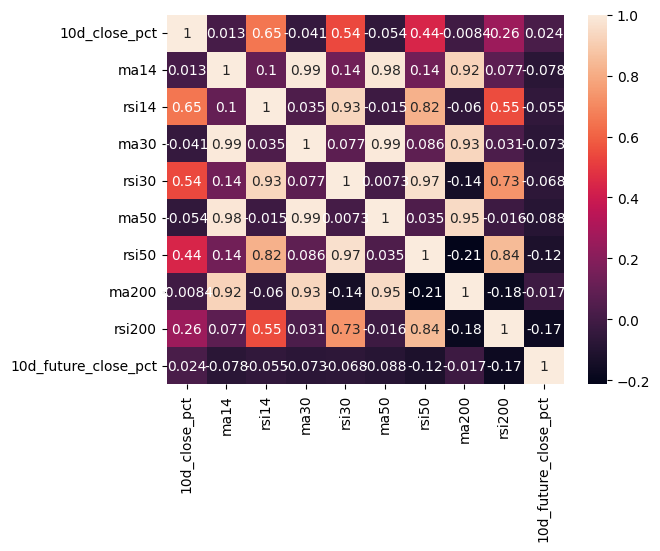

In [115]:

feature_names = ['10d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']
features = yahoo[feature_names]
print(features.head()) 

targets = yahoo['10d_future_close_pct']

feature_target_df = yahoo[feature_names + ['10d_future_close_pct']]

corr = feature_target_df.corr()
sns.heatmap(corr, annot=True)

Linear Modeling with financial data

training data = earliest data
testing data = latest data

Can't use sklearn train-test-split as it randomly shuffles the dataset

In [116]:
# Add a constant to the features
# for linear models needs to add a constant to our features, which adds a columns of 1s for a y intercept term
linear_features = sm.add_constant(features)

print(targets.shape[0])
train_size = int(0.85 * targets.shape[0])

train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]

1825


In [117]:
# fit a linear model
model = sm.OLS(train_targets, train_features)
results = model.fit()
print(results.summary())

MissingDataError: exog contains inf or nans